In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
shift = path_assistant.PathAssistant('shift_03_16_2020')
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
meas_FLAT = pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'), index_col=0)
meas_FLAT = meas_FLAT[meas_FLAT['N']<2.4e7]
meas_FLAT = meas_FLAT.sort_values(by='N',ignore_index=True)

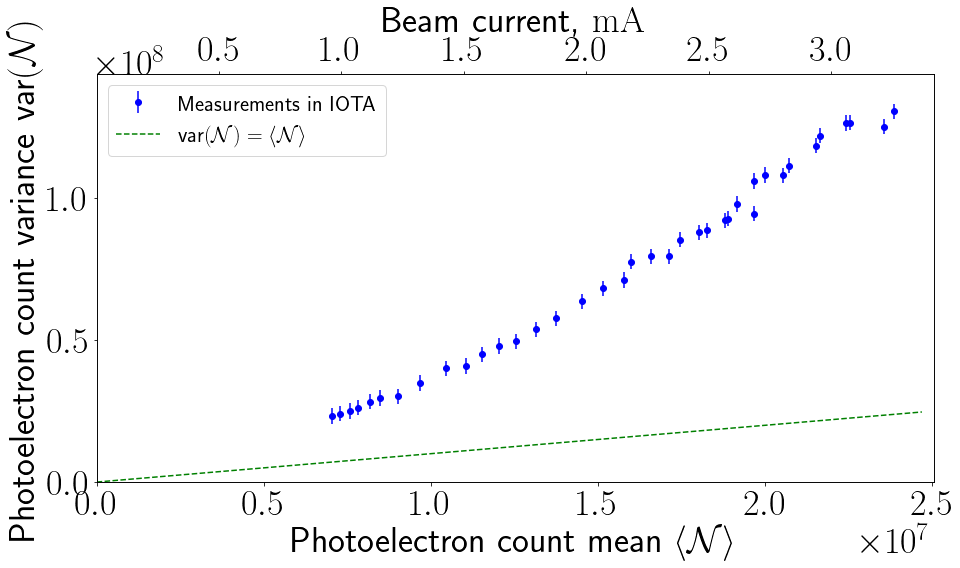

In [3]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
colors = {"FLAT": 'blue'}

fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(meas_FLAT['N'],meas_FLAT['varN'],marker='o',linestyle='None',yerr=meas_FLAT['errorbar'],color='b',
            label = r'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlim(0, 1.05*meas_FLAT['N'].max())
ax.set_ylim(0, 1.1*meas_FLAT['varN'].max())
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, \SI{}{mA}')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[1:-1])
plt.show()

In [32]:
df = pd.read_csv("M_on_grid_precalc.csv", index_col=0)
df_EB = pd.read_csv("M_on_grid_precalc_EB.csv", index_col=0)
df_ET = pd.read_csv("M_on_grid_precalc_ET.csv", index_col=0)
df_exB = pd.read_csv("M_on_grid_precalc_exB.csv", index_col=0)
df_exT = pd.read_csv("M_on_grid_precalc_exT.csv", index_col=0)

In [34]:
df1 = df.apply(lambda row: row.index+row.index**2/row,axis=0)

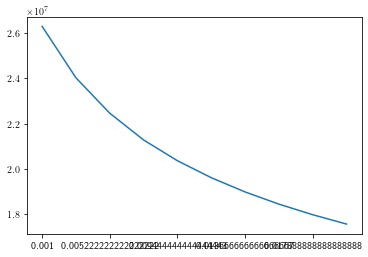

In [35]:
plt.rcParams.update({'font.size': 10,'legend.fontsize':10})
df1.iloc[0,:].plot()

In [36]:
eys = df.columns.values.astype(np.float64)

In [37]:
eys

array([0.001     , 0.00311111, 0.00522222, 0.00733333, 0.00944444,
       0.01155556, 0.01366667, 0.01577778, 0.01788889, 0.02      ])

In [38]:
def reconstruct_ey(avN, varN, en='0'):
    Mexp = avN**2/(varN-avN)
    df0 = {'0':df, 'EB':df_EB, 'ET':df_ET, 'exB':df_exB, 'exT':df_exT}[en]
    return np.interp(Mexp,df0.loc[avN,:],eys)

In [39]:
meas_FLAT.head()

N          varN      errorbar   Sigma_um_X  Sigma_um_Y  \
0  7.033813e+06  2.327259e+07  2.688549e+06  1072.667246   68.017764   
1  7.281579e+06  2.403584e+07  2.688549e+06  1077.585251   68.387617   
2  7.565539e+06  2.507256e+07  2.688549e+06  1083.501358   68.805774   
3  7.831848e+06  2.624953e+07  2.688549e+06  1087.783601   68.966918   
4  8.180763e+06  2.828818e+07  2.688549e+06  1094.360657   69.428513   

    N:IWCMBE    ey_rec       varNtop    varNbottom  ey_error_top  \
0  27.527364  0.004072  2.596114e+07  2.058404e+07      0.004831   
1  27.680173  0.004686  2.672439e+07  2.134729e+07      0.004939   
2  27.830620  0.005174  2.776111e+07  2.238401e+07      0.004931   
3  27.936232  0.005398  2.893808e+07  2.356098e+07      0.004709   
4  28.139613  0.005085  3.097673e+07  2.559963e+07      0.004079   

   ey_error_bottom      I_mA     sy_rec  ey_rec_EB  ey_rec_ET  ey_rec_exB  \
0         0.002794  0.960590  63.300784   0.006814   0.001848    0.005392   
1         0.002884  0.994426  67.908800   0.007640   0.002281    0.006102   
2         0.002909  1.033206  71.355732   0.008335   0.002625    0.006661   
3         0.002866  1.069575  72.885231   0.008631   0.002771    0.006893   
4         0.002590  1.117226  70.742118   0.008212   0.002561    0.006532   

   ey_rec_exT  
0    0.005392  
1    0.006102  
2    0.006661  
3    0.006893  
4    0.006532

In [40]:
reconstruct_ey(meas_FLAT['N'][0], meas_FLAT['varN'][0]+0.01e8)

0.002850331482188667

In [41]:
reconstruct_ey(meas_FLAT['N'][0], meas_FLAT['varN'][0])

0.00407155673581416

In [42]:
meas_FLAT['ey_rec'] = meas_FLAT.apply(
    lambda row: reconstruct_ey(*row[['N', 'varN']]), axis=1)
meas_FLAT['ey_rec_EB'] = meas_FLAT.apply(
    lambda row: reconstruct_ey(*row[['N', 'varN']], en='EB'), axis=1)
meas_FLAT['ey_rec_ET'] = meas_FLAT.apply(
    lambda row: reconstruct_ey(*row[['N', 'varN']], en='ET'), axis=1)
meas_FLAT['ey_rec_exB'] = meas_FLAT.apply(
    lambda row: reconstruct_ey(*row[['N', 'varN']], en='exB'), axis=1)
meas_FLAT['ey_rec_exT'] = meas_FLAT.apply(
    lambda row: reconstruct_ey(*row[['N', 'varN']], en='exT'), axis=1)
meas_FLAT['varNtop'] = meas_FLAT['varN']+meas_FLAT['errorbar']
meas_FLAT['varNbottom'] = meas_FLAT['varN']-meas_FLAT['errorbar']
meas_FLAT['ey_error_top'] = meas_FLAT.apply(
    lambda row: reconstruct_ey(
        *row[['N', 'varNbottom']]), axis=1)\
        - meas_FLAT['ey_rec']
meas_FLAT['ey_error_bottom'] = -meas_FLAT.apply(
    lambda row: reconstruct_ey(
        *row[['N', 'varNtop']]), axis=1)\
        + meas_FLAT['ey_rec']

# Systematic error of reconstructed e due to beam energy uncertainty

In [49]:
1e3*meas_FLAT.loc[:,['ey_rec_EB', 'ey_rec_ET']]\
    .apply(lambda col:col-meas_FLAT.loc[:,'ey_rec'],axis=0)#.abs().apply(np.mean, axis=1)

ey_rec_EB  ey_rec_ET
0    2.742160  -2.223885
1    2.954428  -2.404435
2    3.161540  -2.548211
3    3.232685  -2.627120
4    3.126976  -2.524500
5    3.209322  -2.595838
6    4.178056  -3.463590
7    3.697726  -3.033084
8    3.407780  -2.844062
9    4.312842  -3.602353
10   3.977840  -3.258433
11   4.045355  -3.327974
12   4.424673  -3.708016
13   4.394911  -3.686347
14   4.396645  -3.688342
15   4.308805  -3.598166
16   4.366995  -3.657715
17   4.748150  -3.978078
18   3.941401  -3.209530
19        NaN  -3.735616
20   5.266992  -4.467609
21   4.740434  -3.969913
22   5.124649  -4.331651
23        NaN  -4.567882
24   5.569603  -4.749704
25   5.622608  -4.791688
26        NaN  -4.380728
27   4.180081  -5.530844
28   4.723291  -3.952507
29   4.799716  -4.030207
30   5.455640  -4.659633
31   5.244362  -4.438977
32   5.288777  -4.495756
33   4.965577  -4.199020
34   5.347199  -4.556126
35   5.444063  -4.648897
36   2.891822  -5.880352
37   4.156577  -5.538895

# due to ex error

In [50]:
1e3*meas_FLAT.loc[:,['ey_rec_exB', 'ey_rec_exT']]\
    .apply(lambda col:col-meas_FLAT.loc[:,'ey_rec'],axis=0)#.abs().apply(np.mean, axis=1)

ey_rec_exB  ey_rec_exT
0     1.320667         NaN
1     1.416010   -1.167872
2     1.487556   -1.183527
3     1.494827   -1.204011
4     1.446741   -1.161114
5     1.463837   -1.171822
6     1.830733   -1.509030
7     1.611321   -1.332690
8     1.451438   -1.227220
9     1.812495   -1.520146
10    1.665351   -1.356551
11    1.665312   -1.378464
12    1.820005   -1.528613
13    1.793477   -1.515156
14    1.783928   -1.507459
15    1.735074   -1.467993
16    1.755572   -1.490803
17    1.890893   -1.587577
18    1.596836   -1.291067
19    1.793578   -1.504627
20    2.095071   -1.757676
21    1.891994   -1.586774
22    2.048180   -1.731646
23    2.142801   -1.800449
24    2.230568   -1.879554
25    2.250885   -1.897720
26    2.076717   -1.744159
27    2.591791   -2.179070
28    1.891233   -1.584540
29    1.922509   -1.615434
30    2.182438   -1.837206
31    2.088469   -1.750849
32    2.103338   -1.766016
33    1.985211   -1.679030
34    2.123802   -1.786310
35    2.165893   -1.824777
36    2.695456   -2.282916
37    2.566001   -2.163589

In [12]:
meas_FLAT['I_mA'] = meas_FLAT['N']*N_to_I

In [13]:
# calculation of reconstructed sy
from lattice.summary_in_undulator import CalcTransverseBeamParams
import lattice.lattice as lattice
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))
from scipy.interpolate import interp1d
bp_df = pd.read_csv(shift.get_results_dir().fi("beam_params_vs_current_flat.csv"))
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
def get_sy(row):
    Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
        lattice_df, ex_func(row['N']), row['ey_rec'], dpp_func(row['N']))
    return np.sqrt(Sy**2+syp**2*dy**2)
meas_FLAT["sy_rec"] = meas_FLAT.apply(get_sy, axis=1)

In [14]:
# save new meas_FLAT with ey and I_mA
meas_FLAT.to_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'))

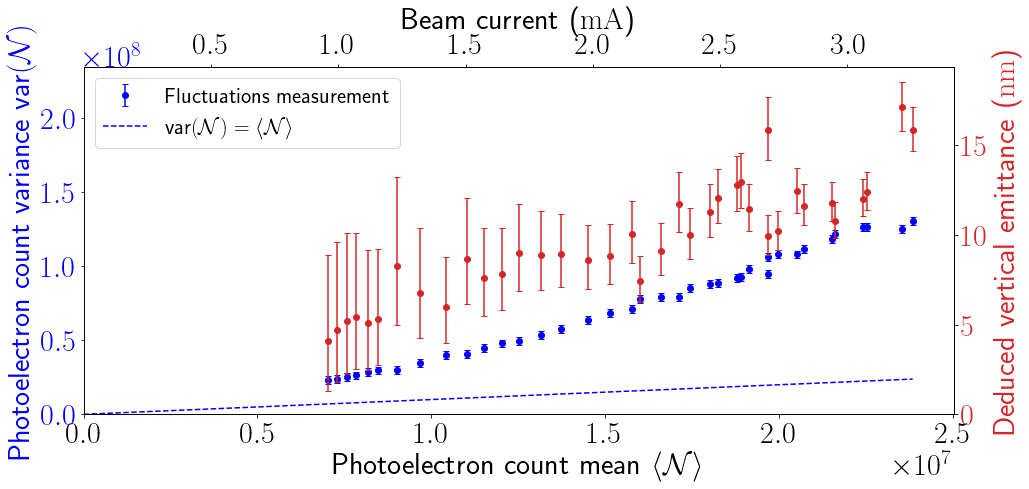

In [15]:
plt.rcParams.update({'font.size': 30,
                     'legend.fontsize':22,
                     'errorbar.capsize': 3})

fig, ax1 = plt.subplots(figsize=[15, 7.5])

color = 'blue'
ax1.set_xlabel('time (s)')
fl = ax1.errorbar(meas_FLAT['N'],meas_FLAT['varN'],marker='o',linestyle='None',
             yerr=meas_FLAT['errorbar'],color=color,
             label = r'Fluctuations measurement')
nrange = np.linspace(0,np.max(meas_FLAT['N']),2)

pois = ax1.plot(nrange, nrange,color=color,linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")

ax1.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$",
               color=color)
ax1.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax1.set_xlim(0, 1.05*meas_FLAT['N'].max())
ax1.set_ylim(0, 1.8*meas_FLAT['varN'].max())

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Deduced vertical emittance (\SI{}{nm})', color=color)
# we already handled the x-label with ax1
yerr = 1e3*np.array([meas_FLAT['ey_error_bottom'],meas_FLAT['ey_error_top']])
#[meas_FLAT['Sigma_um_Y_Meas_Bottom'], meas_FLAT['Sigma_um_Y_Meas_Top']]
ax2.errorbar(meas_FLAT['N'], 1e3*meas_FLAT['ey_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr)
ax2.set_xlim(0, ax2.get_xlim()[1])
ax2.set_ylim(0, ax2.get_ylim()[1])
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twiny()
ax3.set_xlabel('Beam current (\SI{}{mA})')
ax3.set_xlim(N_to_I*np.asarray(ax1.get_xlim()))
ax3.set_xticks(ticks=ax3.get_xticks()[1:-1])

handles, labels = ax1.get_legend_handles_labels()
order = [1,0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc='upper left')


plt.savefig(shift.get_results_dir().fi("size_reconstruction.png"),
            dpi=300, bbox_inches='tight')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

In [16]:
import figure_arrange_scripts as ff
hor_separ = 0.05
v_space = 100
fontsize = 200
im_paths = [shift.get_results_dir().fi("round_beam.png"),
            shift.get_results_dir().fi("size_reconstruction.png")]
output_path = path_assistant.get_PRL_images_dir().fi("iota_measurements.png")

Result saved to /home/ilobach/FUR_Run2_experiment_paper/images/iota_measurements.png


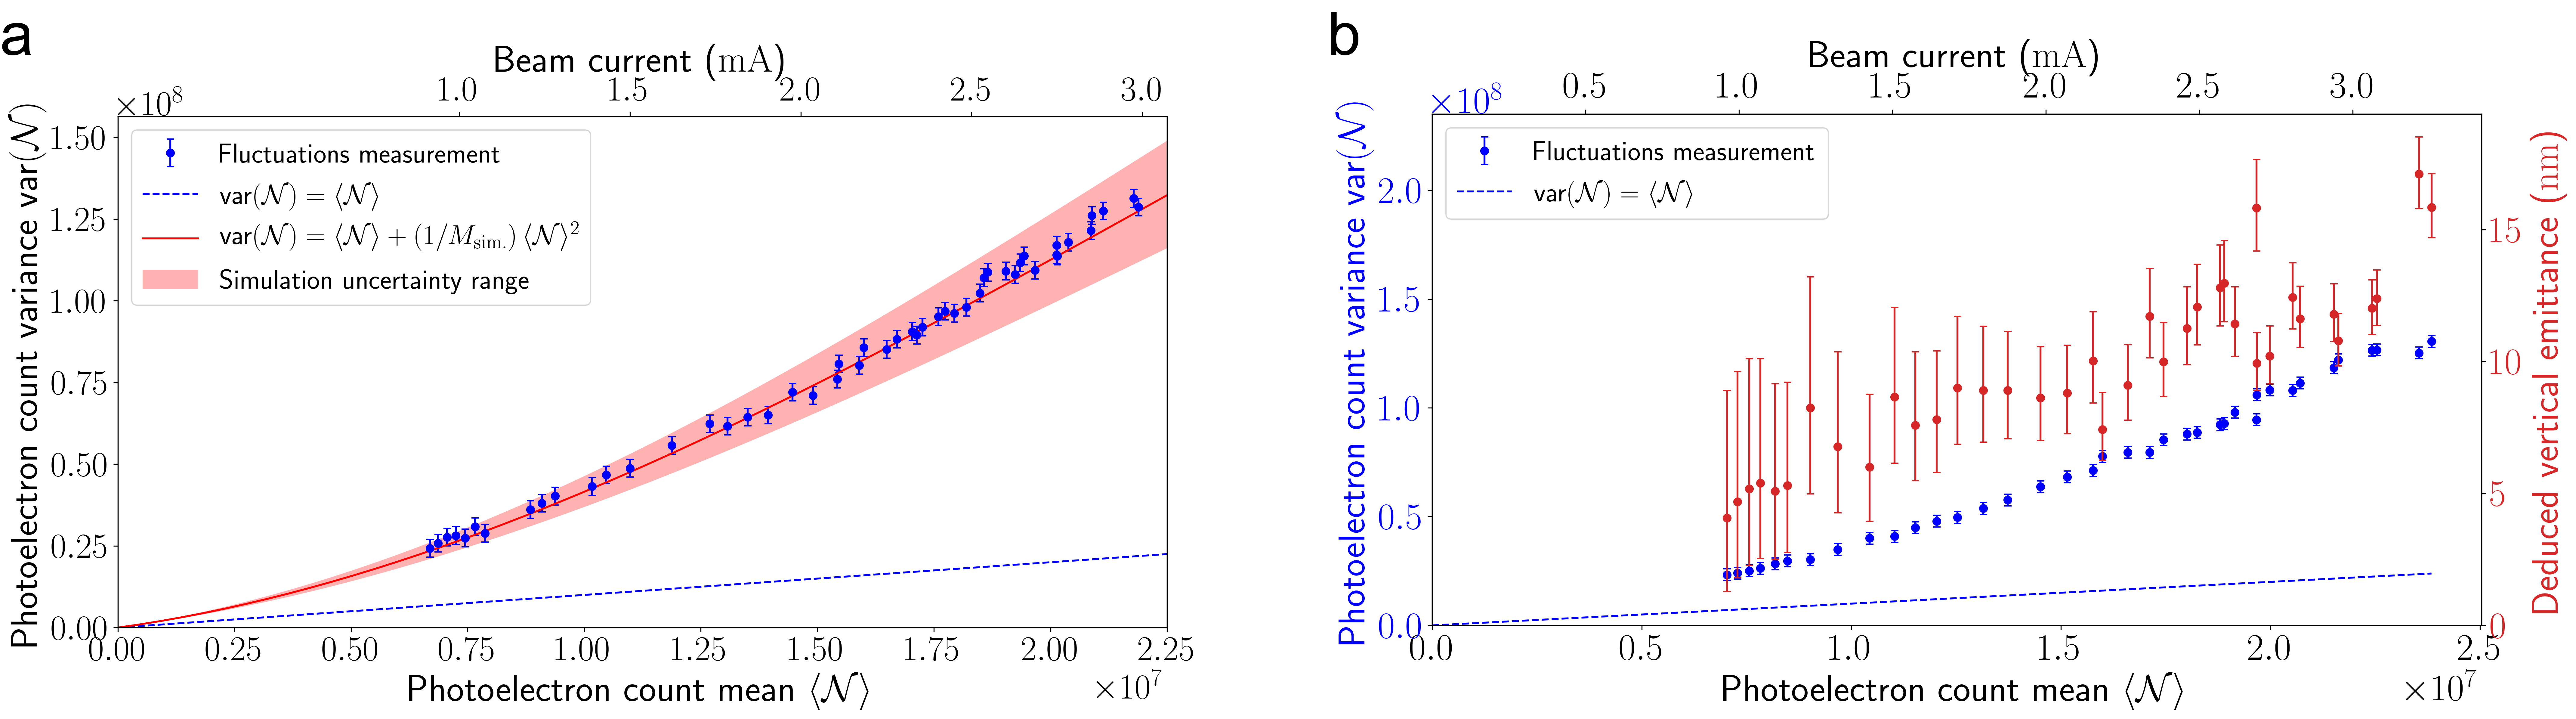

In [17]:
ff.RowOfFigures(im_paths,output_path,
                hor_separ,v_space,fontsize,display_inline=1)

In [18]:
2.29/2.355/3

0.32413305024769995